In [14]:
import pandas as pd
import main

In [15]:
real_top = pd.read_csv('real_data_test\\top_df.csv', delimiter=';')
real_top = real_top.rename(columns={'WELL_NAME': 'WELL_NAME_UWI'})
del real_top['X']
del real_top['Y']
real_top['WELL_NAME_UWI'] = real_top['WELL_NAME_UWI'].astype('str')
real_top.head(n=2)

,WELL_NAME_UWI,DEPTH_TOP
0,100,2548.81
1,101,2556.23


In [16]:
real_bottom = pd.read_csv('real_data_test\\bottom_df.csv', delimiter=';')
real_bottom = real_bottom.rename(columns={'WELL_NAME': 'WELL_NAME_UWI'})
del real_bottom['X']
del real_bottom['Y']
real_bottom['WELL_NAME_UWI'] = real_bottom['WELL_NAME_UWI'].astype('str')
real_bottom.head(n=2)

,WELL_NAME_UWI,DEPTH_BOTTOM
0,100,2564.81
1,101,2571.71


In [17]:
# данные от организаторов
water_content_data = pd.read_csv(main.data_dir + "\\water_content.csv", delimiter=';')
water_content_data = water_content_data.rename(columns={'Скважина': main.keys_dict[main.kid_well]})
water_content_data = water_content_data.rename(columns={' Начальная обводненность ': 'WC'})
water_content_data = water_content_data.rename(columns={'Дата запуска': 'date_start'})
del water_content_data['date_start']
water_content_data = water_content_data.rename(columns={'well_name': 'WELL_NAME'})
water_content_data.head(n=5)
water_content_data['WELL_NAME'] = water_content_data['WELL_NAME'].astype('str')
water_content_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 2 columns):
WELL_NAME    181 non-null object
WC           181 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.9+ KB


In [5]:
print(len(water_content_data['WELL_NAME'].value_counts()))

180


In [18]:
las_out_file_name = 'AllGisParams\\fake_gis_las_all_out.csv'
global_data = pd.read_csv(las_out_file_name, delimiter=';')
global_data['WELL_NAME'] = global_data['WELL_NAME'].astype('str')
global_data['WELL_NAME_UWI'] = global_data['WELL_NAME_UWI'].astype('str')

In [19]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (-1, 1))
las_data = global_data[global_data['WELL_NAME'] == '300']
las_data = las_data['GZ7']
las_data = las_data.dropna()
las_data = scaler.fit_transform(las_data)
las_data

D:\libs\Anaconda\3.3\envs\aind\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\libs\Anaconda\3.3\envs\aind\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([-0.85573923, -0.87270766, -0.88967608, ..., -0.96752092,
       -0.9676667 , -0.96781247])

In [ ]:
#params_name = ['KINT', 'R05', 'R20', 'R14', 'R10', 'F07', 'F10', 'F14', 'R07', 'F20', 'F05', 'PHIT', 'MRES', 'SG', 'KGL', 'SXWB', 'GZ3', 'NPHI', 'GZ2', 'GZ4', 'GZ1', 'CILD', 'PROX', 'LLD', 'GZ7', 'APS', 'KPS', 'GZ5']
#params_name = ['CILD', 'GZ7', 'KINT']
#params_name = ['KINT', 'R05', 'R20', 'R14', 'R10', 'F07', 'F10', 'F14', 'R07', 'F20', 'F05', 'PHIT', 'MRES', 'SG', 'KGL', 'SXWB', 'GZ3', 'NPHI', 'GZ2', 'GZ4', 'GZ1', 'CILD', 'PROX', 'LLD', 'GZ7', 'GR:2', 'GR:1', 'APS', 'KPS', 'GZ5', 'SP:1', 'SP:2', 'W:1', 'W:2', 'NKTM:2', 'NKTM:1', 'CFTC:1', 'CFTC:2', 'MLM:2', 'MLM:1', 'RT:1', 'RT:2', 'GR:3']
params_name = ['R05', 'R14']

In [ ]:
#param = 'KINT'
# las_data = global_data[['WELL_NAME', 'WELL_NAME_UWI', 'DEPT', param]].copy()
# las_data['WELL_NAME'] = las_data['WELL_NAME'].astype('str')
# las_data['WELL_NAME_UWI'] = las_data['WELL_NAME_UWI'].astype('str')
# las_data = las_data.dropna()

In [ ]:
# объединение данных по всем параметрам
min_count_val_in_data = 10
count_val = 100


# Загружаем данные по параметру
# las_gis_file_name = 'AllGisParams\\fake_gis_las_' + param_name_file +  '_out.csv'
# las_data = pd.read_csv(las_gis_file_name, delimiter=';', low_memory=False)
print('Start union table')
all_params = ['WELL_NAME', 'WELL_NAME_UWI', 'DEPT']
all_params.extend(params_name)
las_data = global_data[all_params].copy()
las_data['WELL_NAME'] = las_data['WELL_NAME'].astype('str')
las_data['WELL_NAME_UWI'] = las_data['WELL_NAME_UWI'].astype('str')
las_data.head(n=5)

# Объединяем данные
real_data = pd.merge(water_content_data, las_data, on='WELL_NAME')
real_data = pd.merge(real_data, real_top, on='WELL_NAME_UWI')
real_data = pd.merge(real_data, real_bottom, on='WELL_NAME_UWI')
real_data_na = real_data.dropna()
print(len(real_data['WELL_NAME'].value_counts()))

# Преобразуем в данные для обучения
dev_path = "..\\tasks\\task 6\\data\\dev\\"
well_name_list = real_data_na['WELL_NAME_UWI'].value_counts().index.tolist()

x_values = []
for param in params_name:
    params_name_file = (param.replace(':','')).lower()
    print('Convert ', param, 'start')

#     [x_values_temp, y_values, y_names] = main.ConvertDataToLearningByStdParams(real_data_na, param, dev_path,
#                                                            min_count_val_in_data)
    [x_values_temp, y_values, y_names] = main.ConvertDataToLearning(real_data_na, param, dev_path,
                                                               min_count_val_in_data, count_val)
    if (len(x_values) > 0):
        for src, res in zip(x_values_temp, x_values):
            res.extend(src)
            #print('res = ',len(res), 'src = ', len(src))
    else:
        x_values = x_values_temp.copy()
                
    print('length =', len(x_values), len(y_values), len(x_values[0]))
    

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score

y_values_r = y_values
x_train, x_hold, y_train, y_hold = train_test_split(x_values, y_values_r, test_size=0.3, random_state=17)
# обучаем дерево
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

forest = RandomForestRegressor(n_estimators=10, n_jobs=---1, random_state=17) # n_jobs=-1
# print(np.mean(cross_val_score(forest, x_hold, y_hold, cv=6))) # 0.949


forest_params = { 
    'max_depth': [1, 10, 20, 40, 60],
    'n_estimators': [1, 10, 30, 50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2']
}

print('Start', param, ' learning')
forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)
forest_grid.fit(x_train, y_train) 
print('Convert all_params end')
print(len(x_values))

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

def data_analize_func(predict_for_analize, file_name = ''):
    # подготовка данных
    data_for_analize = predict_for_analize.sort_values(by=['y_hold'])
    data_for_analize['x_axis'] = [x for x in range(len(predict_for_analize['y_hold']))]
    data_for_analize.head()
    if file_name != '':
        data_for_analize.to_csv('AllGisParams/' + file_name, index=False, sep = ';')
    
    # построение графиков
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_predict'], color = 'blue')
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_hold'], color = 'red')
    plt.show()
    
    # regression metrics
    print('MSE                      = '+ str(mean_squared_error(data_for_analize['y_hold'], 
                                                                data_for_analize['y_predict'])))
    print('MAE                      = '+ str(mean_absolute_error(data_for_analize['y_hold'], 
                                                                 data_for_analize['y_predict'])))
    print('r2_score                 = '+ str(r2_score(data_for_analize['y_hold'], 
                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')
    print('explained_variance_score = '+ str(explained_variance_score(data_for_analize['y_hold'], 
                                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')

In [ ]:
predict_for_analize_fake = pd.DataFrame({'y_hold':y_hold, 'y_predict':forest_grid.predict(x_hold)})
data_analize_func(predict_for_analize_fake)
#predict_for_analize_fake.to_csv('AllGisParams/result_predict_sum.csv',index=False, sep = ';')

In [22]:
# проверка по каждому параметру
params_name = ['KINT', 'R05', 'R20', 'R14', 'R10', 'F07', 'F10', 'F14', 'R07', 'F20', 'F05', 'PHIT', 'MRES', 'SG', 'KGL', 'SXWB', 'GZ3', 'NPHI', 'GZ2', 'GZ4', 'GZ1', 'CILD', 'PROX', 'LLD', 'GZ7', 'APS', 'KPS', 'GZ5']
#params_name = ['R10']
result_mse = {}.fromkeys(params_name, 0)
result_mae= {}.fromkeys(params_name, 0)
result_r2 = {}.fromkeys(params_name, 0)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
count_val = 500
min_count_val_in_data = 10
for param in params_name:
    print('Convert ', param, 'start')
    param_name_file = (param.replace(':','')).lower()
    # Загружаем данные по параметру
    # las_gis_file_name = 'AllGisParams\\fake_gis_las_' + param_name_file +  '_out.csv'
    # las_data = pd.read_csv(las_gis_file_name, delimiter=';', low_memory=False)
    las_data = global_data[['WELL_NAME', 'WELL_NAME_UWI', 'DEPT', param]].copy()
    las_data['WELL_NAME'] = las_data['WELL_NAME'].astype('str')
    las_data['WELL_NAME_UWI'] = las_data['WELL_NAME_UWI'].astype('str')
    las_data.head(n=5)
    
    # Объединяем данные
    real_data = pd.merge(water_content_data, las_data, on='WELL_NAME')
    real_data = pd.merge(real_data, real_top, on='WELL_NAME_UWI')
    real_data = pd.merge(real_data, real_bottom, on='WELL_NAME_UWI')
    real_data_na = real_data.dropna()
    print(len(real_data['WELL_NAME'].value_counts()))
    
    if (param == 'CILD'):
        real_data_na = real_data_na[real_data_na[param] > 0] 
    
    # Преобразуем в данные для обучения
    dev_path = "..\\tasks\\task 6\\data\\dev\\"
    well_name_list = real_data_na['WELL_NAME_UWI'].value_counts().index.tolist()
#     [x_values, y_values, y_names] = main.ConvertDataToLearningStatParamsWithDiff(real_data_na, param, dev_path,
#                                                                min_count_val_in_data, count_val)
#     [x_values, y_values, y_names] = main.ConvertDataToLearningByStdParams(real_data_na, param, dev_path,
#                                                                           min_count_val_in_data)
    [x_values, y_values, y_names] = main.ConvertDataToLearningByStdParams(real_data_na, param, dev_path, min_count_val_in_data)
    
    # y_values_r = [int(10 * y_val) for y_val in y_values]
    y_values_r = y_values
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split, StratifiedKFold
    from sklearn.metrics import accuracy_score
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.cross_validation import cross_val_score

    x_train, x_hold, y_train, y_hold = train_test_split(x_values, y_values_r, test_size=0.3, random_state=17)
    # обучаем дерево
    # from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import RandomForestRegressor
    
    from sklearn.model_selection import GridSearchCV, cross_val_score
    forest = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=17)
    forest_params = { 
        # 'max_depth': [1, 2, 3, 5, 10, 20, 40, 60],
        'max_depth': [1, 2, 3, 5, 7, 10],
        'n_estimators': [1, 10, 30, 50, 100, 200, 500],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    print('Start', param, ' learning')
    from sklearn.model_selection import LeaveOneOut
    #loo = LeaveOneOut()
    forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)
    forest_grid.fit(x_train, y_train) 
     #result_fit = accuracy_score(y_hold, forest_grid.predict(x_hold))
    print('best_params', forest_grid.best_params_)
    y_predict = forest_grid.predict(x_hold) 
    
#     from sklearn.ensemble import GradientBoostingRegressor
#     boost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, 
#                                            max_depth=2, random_state=17, loss='ls')
#     boost.fit(x_train, y_train)
#     y_predict = boost.predict(x_hold) 
    # print(np.mean(cross_val_score(forest, x_hold, y_hold, cv=6))) # 0.949
    
   
    mse = mean_squared_error(y_hold, y_predict)
    mae = mean_absolute_error(y_hold, y_predict)
    # r2_score =  r2_score(y_hold, y_predict)

    result_mse[param] = mse
    result_mae[param] = mae
    #result_r2[param] = r2_score
    print('result_mae = ', 100. * mae)
    print('Convert', param, 'end')
print('End calculate, l_values_len = ', len(x_values))

Convert  KINT start
157
0  of  154
20  of  154
40  of  154
60  of  154
80  of  154
100  of  154
120  of  154
140  of  154
end ConvertDataToLearning
x_values_length =  151
Start KINT  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.3min finished


best_params {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 10}
result_mae =  13.3044317883
Convert KINT end
Convert  R05 start
157
0  of  155
20  of  155
40  of  155
60  of  155
80  of  155
100  of  155
120  of  155
140  of  155
end ConvertDataToLearning
x_values_length =  152
Start R05  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50}
result_mae =  12.7050185252
Convert R05 end
Convert  R20 start
157
0  of  155
20  of  155
40  of  155
60  of  155
80  of  155
100  of  155
120  of  155
140  of  155
end ConvertDataToLearning
x_values_length =  152
Start R20  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
result_mae =  12.6290815115
Convert R20 end
Convert  R14 start
157
0  of  155
20  of  155
40  of  155
60  of  155
80  of  155
100  of  155
120  of  155
140  of  155
end ConvertDataToLearning
x_values_length =  152
Start R14  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 100}
result_mae =  11.2051578693
Convert R14 end
Convert  R10 start
157
0  of  155
20  of  155
40  of  155
60  of  155
80  of  155
100  of  155
120  of  155
140  of  155
end ConvertDataToLearning
x_values_length =  152
Start R10  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.3min finished


best_params {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 100}
result_mae =  10.9040853497
Convert R10 end
Convert  F07 start
157
0  of  155
0  of  155
20  of  155
40  of  155
60  of  155
80  of  155
100  of  155
120  of  155
140  of  155
end ConvertDataToLearning
x_values_length =  152
Start F07  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100}
result_mae =  11.5758198661
Convert F07 end
Convert  F10 start
157
0  of  155
0  of  155
20  of  155
40  of  155
40  of  155
60  of  155
80  of  155
100  of  155
120  of  155
140  of  155
end ConvertDataToLearning
x_values_length =  152
Start F10  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 500}
result_mae =  11.6651417508
Convert F10 end
Convert  F14 start
157
0  of  155
0  of  155
20  of  155
40  of  155
40  of  155
60  of  155
80  of  155
100  of  155
120  of  155
140  of  155
end ConvertDataToLearning
x_values_length =  152
Start F14  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 200}
result_mae =  11.7114957779
Convert F14 end
Convert  R07 start
157
0  of  155
20  of  155
40  of  155
60  of  155
80  of  155
100  of  155
120  of  155
140  of  155
end ConvertDataToLearning
x_values_length =  152
Start R07  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 7, 'max_features': 'auto', 'n_estimators': 50}
result_mae =  14.9418053758
Convert R07 end
Convert  F20 start
157
0  of  155
0  of  155
20  of  155
40  of  155
40  of  155
60  of  155
80  of  155
100  of  155
120  of  155
140  of  155
end ConvertDataToLearning
x_values_length =  152
Start F20  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 10}
result_mae =  12.2085116489
Convert F20 end
Convert  F05 start
157
0  of  155
0  of  155
20  of  155
40  of  155
60  of  155
80  of  155
100  of  155
120  of  155
140  of  155
end ConvertDataToLearning
x_values_length =  152
Start F05  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 200}
result_mae =  12.0941634494
Convert F05 end
Convert  PHIT start
157
0  of  153
20  of  153
40  of  153
60  of  153
80  of  153
100  of  153
120  of  153
140  of  153
end ConvertDataToLearning
x_values_length =  150
Start PHIT  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 10}
result_mae =  12.4983407673
Convert PHIT end
Convert  MRES start
157
0  of  154
20  of  154
40  of  154
60  of  154
80  of  154
100  of  154
120  of  154
140  of  154
end ConvertDataToLearning
x_values_length =  150
Start MRES  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 100}
result_mae =  12.2612935876
Convert MRES end
Convert  SG start
157
0  of  153
20  of  153
40  of  153
60  of  153
80  of  153
100  of  153
120  of  153
140  of  153
end ConvertDataToLearning
x_values_length =  149
Start SG  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.3min finished


best_params {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 100}
result_mae =  12.3255365939
Convert SG end
Convert  KGL start
157
0  of  152
20  of  152
40  of  152
60  of  152
80  of  152
100  of  152
120  of  152
140  of  152
end ConvertDataToLearning
x_values_length =  149
Start KGL  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 100}
result_mae =  14.8875253618
Convert KGL end
Convert  SXWB start
157
0  of  151
20  of  151
40  of  151
60  of  151
80  of  151
100  of  151
120  of  151
140  of  151
end ConvertDataToLearning
x_values_length =  148
Start SXWB  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 500}
result_mae =  13.8167442412
Convert SXWB end
Convert  GZ3 start
157
0  of  156
20  of  156
40  of  156
60  of  156
80  of  156
100  of  156
120  of  156
140  of  156
end ConvertDataToLearning
x_values_length =  153
Start GZ3  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 10}
result_mae =  13.8956637679
Convert GZ3 end
Convert  NPHI start
157
0  of  154
20  of  154
40  of  154
60  of  154
80  of  154
100  of  154
120  of  154
140  of  154
end ConvertDataToLearning
x_values_length =  148
Start NPHI  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 1, 'max_features': 'auto', 'n_estimators': 30}
result_mae =  12.7196421153
Convert NPHI end
Convert  GZ2 start
157
0  of  156
20  of  156
40  of  156
60  of  156
80  of  156
100  of  156
120  of  156
140  of  156
end ConvertDataToLearning
x_values_length =  153
Start GZ2  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 1, 'max_features': 'auto', 'n_estimators': 10}
result_mae =  12.7565185135
Convert GZ2 end
Convert  GZ4 start
157
0  of  156
20  of  156
40  of  156
60  of  156
80  of  156
100  of  156
120  of  156
140  of  156
end ConvertDataToLearning
x_values_length =  153
Start GZ4  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 500}
result_mae =  11.4522600865
Convert GZ4 end
Convert  GZ1 start
157
0  of  156
20  of  156
40  of  156
60  of  156
80  of  156
100  of  156
120  of  156
140  of  156
end ConvertDataToLearning
x_values_length =  153
Start GZ1  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.3min finished


best_params {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 10}
result_mae =  11.9786537917
Convert GZ1 end
Convert  CILD start
157
0  of  156
20  of  156
40  of  156
60  of  156
80  of  156
100  of  156
120  of  156
140  of  156
end ConvertDataToLearning
x_values_length =  153
Start CILD  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.3min finished


best_params {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 500}
result_mae =  12.9416726862
Convert CILD end
Convert  PROX start
157
0  of  155
20  of  155
40  of  155
60  of  155
80  of  155
100  of  155
120  of  155
140  of  155
end ConvertDataToLearning
x_values_length =  151
Start PROX  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 1}
result_mae =  13.8913043478
Convert PROX end
Convert  LLD start
157
0  of  156
20  of  156
40  of  156
60  of  156
80  of  156
100  of  156
120  of  156
140  of  156
end ConvertDataToLearning
x_values_length =  153
Start LLD  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.3min finished


best_params {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 1}
result_mae =  13.3825281218
Convert LLD end
Convert  GZ7 start
157
0  of  154
20  of  154
40  of  154
60  of  154
80  of  154
100  of  154
120  of  154
140  of  154
end ConvertDataToLearning
x_values_length =  151
Start GZ7  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 1, 'max_features': 'auto', 'n_estimators': 30}
result_mae =  11.3475703077
Convert GZ7 end
Convert  APS start
157
0  of  145
20  of  145
40  of  145
60  of  145
80  of  145
100  of  145
120  of  145
140  of  145
end ConvertDataToLearning
x_values_length =  

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


142
Start APS  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits
best_params {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 10}
result_mae =  14.9336701617
Convert APS end
Convert  KPS start
157
0  of  146
20  of  146
40  of  146
60  of  146
80  of  146
100  of  146
120  of  146
140  of  146
end ConvertDataToLearning
x_values_length =  143
Start KPS  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 30}
result_mae =  13.8231958414
Convert KPS end
Convert  GZ5 start
157
0  of  156
20  of  156
40  of  156
60  of  156
80  of  156
100  of  156
120  of  156
140  of  156
end ConvertDataToLearning
x_values_length =  153
Start GZ5  learning
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.2min finished


best_params {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 100}
result_mae =  14.0635312108
Convert GZ5 end
End calculate, l_values_len =  153


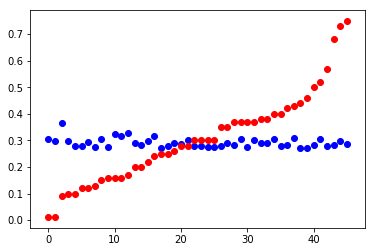

MSE                      = 0.0314740395064
MAE                      = 0.140635312108
r2_score                 = -0.0751218423188    (best_value is 1)
explained_variance_score = -0.0678212234906    (best_value is 1)


In [23]:
predict_for_analize_fake = pd.DataFrame({'y_hold':y_hold, 'y_predict':y_predict})
data_analize_func(predict_for_analize_fake)
#predict_for_analize_fake.to_csv('AllGisParams/result_predict_sum_r05.csv',index=False, sep = ';')

In [24]:
predict_for_analize_mae = pd.DataFrame(list(result_mae.items()), columns=['Param', 'Mae'])
predict_for_analize_mae.to_csv('AllGisParams/result_mae_diff(std_param).csv',index=False, sep = ';')
predict_for_analize_mse = pd.DataFrame(list(result_mse.items()), columns=['Param', 'Mse'])
predict_for_analize_mse.to_csv('AllGisParams/result_mse_diff(std_param).csv',index=False, sep = ';')

In [ ]:
#result_learning.items()
result_data = pd.DataFrame(list(result_learning.items()), columns=['Param', 'Result'])

In [ ]:
result_data.to_csv('AllGisParams/result_learning_std.csv',index=False, sep = ';')

In [ ]:
# Создаем DataFrame
# x_names = ['idx' + str(i) for i in range(len(x_values[0]))]
# data_x_values = pd.DataFrame(x_values, columns = x_names)
# data_y_values = pd.DataFrame(y_values, columns=['wc'])
# data_names = pd.DataFrame(y_names, columns=['WELL_NAME'])
# len(data_x_values)
# data_values = pd.merge(data_y_values, data_names, left_index=True, right_index=True)
# data_values = pd.merge(data_values, data_x_values, left_index=True, right_index=True)

In [ ]:
data_values.head()